**PCA and SVM**
1. Imports

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd


2. Image processing


In [2]:
images = []
labels = []

data_dir = r'.\archive\asl_alphabet_train\asl_alphabet_train'
selected_letters = ['A', 'B', 'F', 'I', 'J', 'L', 'O', 'P', 'V', 'Y']
size = 100

for letter_dir in os.listdir(data_dir):
    
    # Check if the entry is a directory
    if os.path.isdir(os.path.join(data_dir, letter_dir)) and letter_dir in selected_letters:
        # Iterate over the files in the letter directory
        for file in os.listdir(os.path.join(data_dir, letter_dir)):
            # Check if the file is a jpg image
            if file.endswith('.jpg'):
                # Read the image
                image_path = os.path.join(data_dir, letter_dir, file)
                image = cv2.imread(image_path)

                # Resize, convert to grayscale, and normalize pixel values
                image_resized = cv2.resize(image, (size, size))
                image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
                image_normalized = image_gray / 255.0 

                # Extract label from filenames
                label = file[0]
                
                images.append(image_normalized)
                labels.append(label)

In [3]:
# Flatten the images and convert the list to a numpy array
images = np.array(images)
images = images.flatten().reshape(images.shape[0], size * size)
labels = np.array(labels)
print(images.shape)

(30000, 10000)


3. Display images for testing

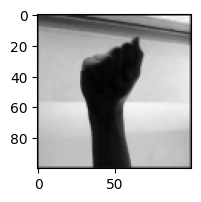

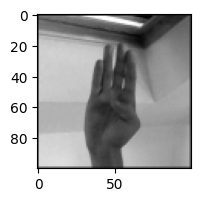

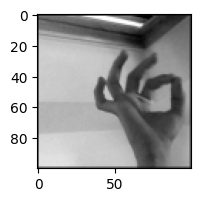

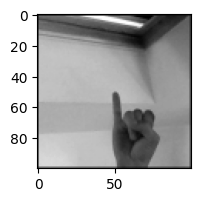

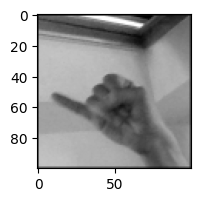

In [4]:
vals = [0, 3010, 6020, 9030, 12040]
for i in vals:
  # Reshape from flat array to square matrix
  sq_matrix = np.reshape(images[i], (size, size))

  fig, ax = plt.subplots(figsize=(2,2))
  plt.imshow(sq_matrix, cmap='gray')
  plt.show()


4. Dimensionality reduction using Principle Component Analysis<br>
4.1 Eigenvectors

In [5]:
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(images)


PCA(n_components=150)

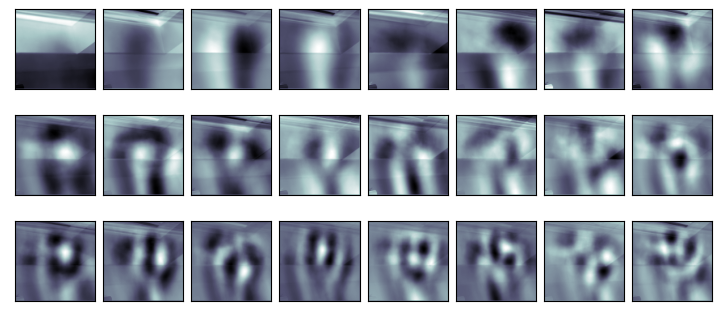

In [6]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(size, size), cmap='bone')

Text(0, 0.5, 'cumulative explained variance')

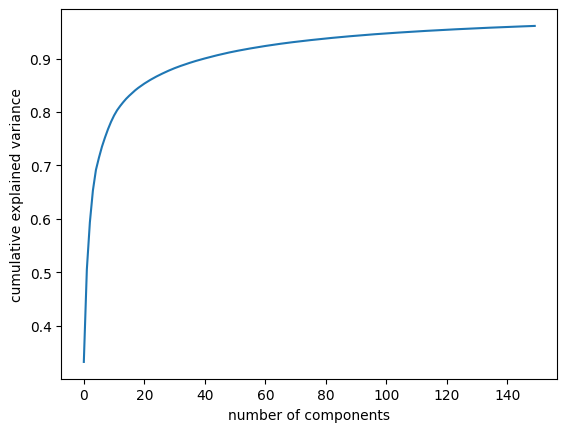

In [7]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [8]:
# Compute the components and projected hands
pca = RandomizedPCA(150).fit(images)
components = pca.transform(images)
projected = pca.inverse_transform(components)
print (components.shape)
print (projected.shape)

(30000, 150)
(30000, 10000)


Text(0, 0.5, '150-dim\nreconstruction')

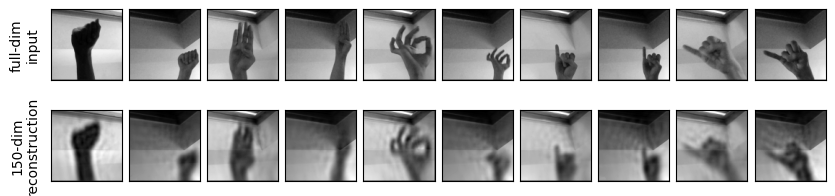

In [9]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
vals = [0, 1500, 3010, 4500, 6020, 7500, 9030, 10500, 12040, 13500]

for val, i in zip(vals, range(10)):
    ax[0, i].imshow(images[val].reshape(size, size), cmap='binary_r')
    ax[1, i].imshow(projected[val].reshape(size, size), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction')

['J' 'J' 'J' ... 'I' 'I' 'A']
(7500,) (7500,)


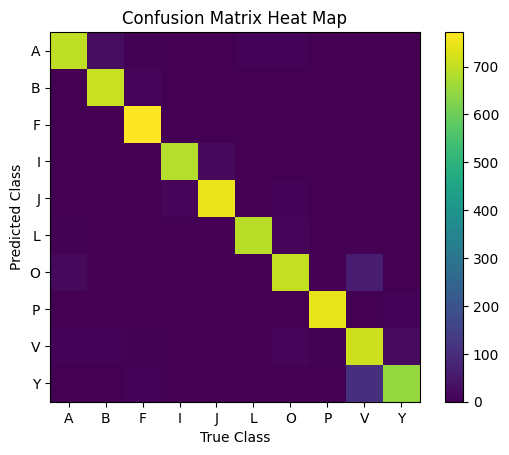

In [10]:
#function that you will use to convert matrix to dataframe, useful for visulization.
def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)
x_train, x_test, y_train, y_test = train_test_split(components, labels, random_state=0,test_size=0.25)
print(y_train)
svc = SVC(kernel='poly')
svc.fit(x_train, y_train)
svc_y_pred = svc.predict(x_test)
print(y_test.shape, svc_y_pred.shape)

conf_matrix = confusion_matrix(y_test, svc_y_pred)
conf_matrix_to_df(conf_matrix, np.unique(labels))


plt.imshow(conf_matrix)
plt.colorbar()

plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.title('Confusion Matrix Heat Map')

class_names = ['A', 'B', 'F', 'I', 'J', 'L', 'O', 'P', 'V', 'Y']
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)

plt.show()

In [11]:
class_report = classification_report(y_test, svc_y_pred)
print(class_report)

              precision    recall  f1-score   support

           A       0.96      0.94      0.95       744
           B       0.95      0.98      0.97       723
           F       0.97      1.00      0.98       774
           I       0.98      0.97      0.97       706
           J       0.97      0.97      0.97       772
           L       0.99      0.97      0.98       714
           O       0.94      0.90      0.92       782
           P       0.99      0.99      0.99       752
           V       0.81      0.92      0.86       773
           Y       0.95      0.85      0.90       760

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500

